In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib

#system
from pathlib import Path
import time

#ai
import torch
from torch import nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import src
importlib.reload(src)

import src.utils.metrics as metrics
import src.utils.gau as gaussian
import src.utils.plots as plots

from src.models import AE, RNN, LinearClassifier, get_latent_features, rnn_loss_function, ae_loss_function
from src.training import EarlyStopping, train_ae, train_rnn, train_lp, augment_data

from src.final_model import ae_loss_function, rnn_loss_function

c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
stamps_dataset = pd.read_pickle('data/5stamps_dataset.pkl')

def rename_labels(dataset, old_value, new_value):
    for key in dataset.keys():
        if old_value in dataset[key]:
            dataset[key][new_value] = dataset[key].pop(old_value)

rename_labels(stamps_dataset, 'labels', 'class')
rename_labels(stamps_dataset, 'science', 'images')

In [4]:
train_template = torch.tensor(stamps_dataset['Train']['template'], dtype=torch.float32)
validation_template = torch.tensor(stamps_dataset['Validation']['template'], dtype=torch.float32)
test_template = torch.tensor(stamps_dataset['Test']['template'], dtype=torch.float32)

train_difference = torch.tensor(stamps_dataset['Train']['difference'], dtype=torch.float32)
validation_difference = torch.tensor(stamps_dataset['Validation']['difference'], dtype=torch.float32)
test_difference = torch.tensor(stamps_dataset['Test']['difference'], dtype=torch.float32)

train_image = torch.tensor(stamps_dataset['Train']['images'], dtype=torch.float32)
validation_image = torch.tensor(stamps_dataset['Validation']['images'], dtype=torch.float32)
test_image = torch.tensor(stamps_dataset['Test']['images'], dtype=torch.float32)

train_class_0 = torch.tensor(stamps_dataset['Train']['class'], dtype=torch.float32)
validation_class_0 = torch.tensor(stamps_dataset['Validation']['class'], dtype=torch.float32)
test_class_0 = torch.tensor(stamps_dataset['Test']['class'], dtype=torch.float32)

train_template = train_template.unsqueeze(1).repeat(1, 5, 1, 1)
validation_template = validation_template.unsqueeze(1).repeat(1, 5, 1, 1)
test_template = test_template.unsqueeze(1).repeat(1, 5, 1, 1)


train_dataset = torch.stack((train_template, train_image, train_difference), dim=3  )
validation_dataset = torch.stack((validation_template, validation_difference, validation_difference), dim=3)
test_dataset = torch.stack((test_template, test_image, test_difference), dim=3)

train_template = train_template.unsqueeze(2)  # (samples, 5, 1, 21, 21)
train_image = train_image.unsqueeze(2)        
train_difference = train_difference.unsqueeze(2)  

validation_template = validation_template.unsqueeze(2)
validation_image = validation_image.unsqueeze(2)
validation_difference = validation_difference.unsqueeze(2)

test_template = test_template.unsqueeze(2)
test_image = test_image.unsqueeze(2)
test_difference = test_difference.unsqueeze(2)

# Apilar los tensores a lo largo de la dimensión correcta
train_dataset = torch.cat((train_template, train_image, train_difference), dim=2)
validation_dataset = torch.cat((validation_template, validation_image, validation_difference), dim=2)
test_dataset = torch.cat((test_template, test_image, test_difference), dim=2)

# Crear los conjuntos de datos
train_dataset = TensorDataset(train_dataset, train_class_0)
validation_dataset = TensorDataset(validation_dataset, validation_class_0)
test_dataset = TensorDataset(test_dataset, test_class_0)

In [40]:
#rnn parameters
rnn_type = 'LSTM'
hidden_dim = 42
num_layers = 2

# autoencoder params
latent_dim = 42
n_channels = 3
n_classes = 3

# training params
ae_loss = ae_loss_function
rnn_loss = rnn_loss_function

max_epochs = 300
max_time = 500 #minutos
lr = 10e-5
batch_size = 256
dropout_prob = 0

random_sampler = True
use_gpu = True
augmentation = False
only_classifier = False
early_stop = 50
num_cpu = 0

In [ ]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)


# modelo_final = fm.FinalModel(128, 3, 'LSTM', 128, 1, 0,  3, name='4th_iteration')
# modelo_final.load_state_dict(torch.load(f'models/2_2.pth'))

modelo_final = fm.FinalModel(latent_dim, n_channels, rnn_type, hidden_dim, num_layers, dropout_prob,  n_classes, name='3rd_iteration')

early_stop = 5
batch_size = 32

stage = 'ae_rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                lr,
                                                random_sampler,
                                                only_classifier,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), f'models/{modelo_final.name}.pth')


Setup finishied. Starting training...
(0.01 min) Epoch 1/300 -- Iteration 4 - Batch 4/482 - Train loss: 0.06521445  - Train acc: -0.0000 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 8 - Batch 8/482 - Train loss: 0.04957664  - Train acc: -0.0000 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 12 - Batch 12/482 - Train loss: 0.04326821  - Train acc: -0.0000 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 16 - Batch 16/482 - Train loss: 0.03936186  - Train acc: -0.0000 - Val loss: 0.00000000
(0.02 min) Epoch 1/300 -- Iteration 20 - Batch 20/482 - Train loss: 0.03662345  - Train acc: -0.0000 - Val loss: 0.00000000
(0.02 min) Epoch 1/300 -- Iteration 24 - Batch 24/482 - Train loss: 0.03476414  - Train acc: -0.0000 - Val loss: 0.00000000
(0.02 min) Epoch 1/300 -- Iteration 28 - Batch 28/482 - Train loss: 0.03333682  - Train acc: -0.0000 - Val loss: 0.00000000
(0.02 min) Epoch 1/300 -- Iteration 32 - Batch 32/482 - Train loss: 0.03195597  - Train acc: -0.0

KeyboardInterrupt: 

In [15]:
modelo_final.cpu()
torch.save(modelo_final.state_dict(), f'models/{modelo_final.name}.pth')

In [58]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

modelo_final = fm.FinalModel(latent_dim, n_channels, rnn_type, hidden_dim, num_layers, dropout_prob,  n_classes, name='2nd_iteration')
modelo_final.load_state_dict(torch.load(f'models/aernn_final.pth'))

C:\Users\pmarc\AppData\Local\Temp\ipykernel_24488\2805212558.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_final.load_state_dict(torch.load(f'models/aernn_final

<All keys matched successfully>

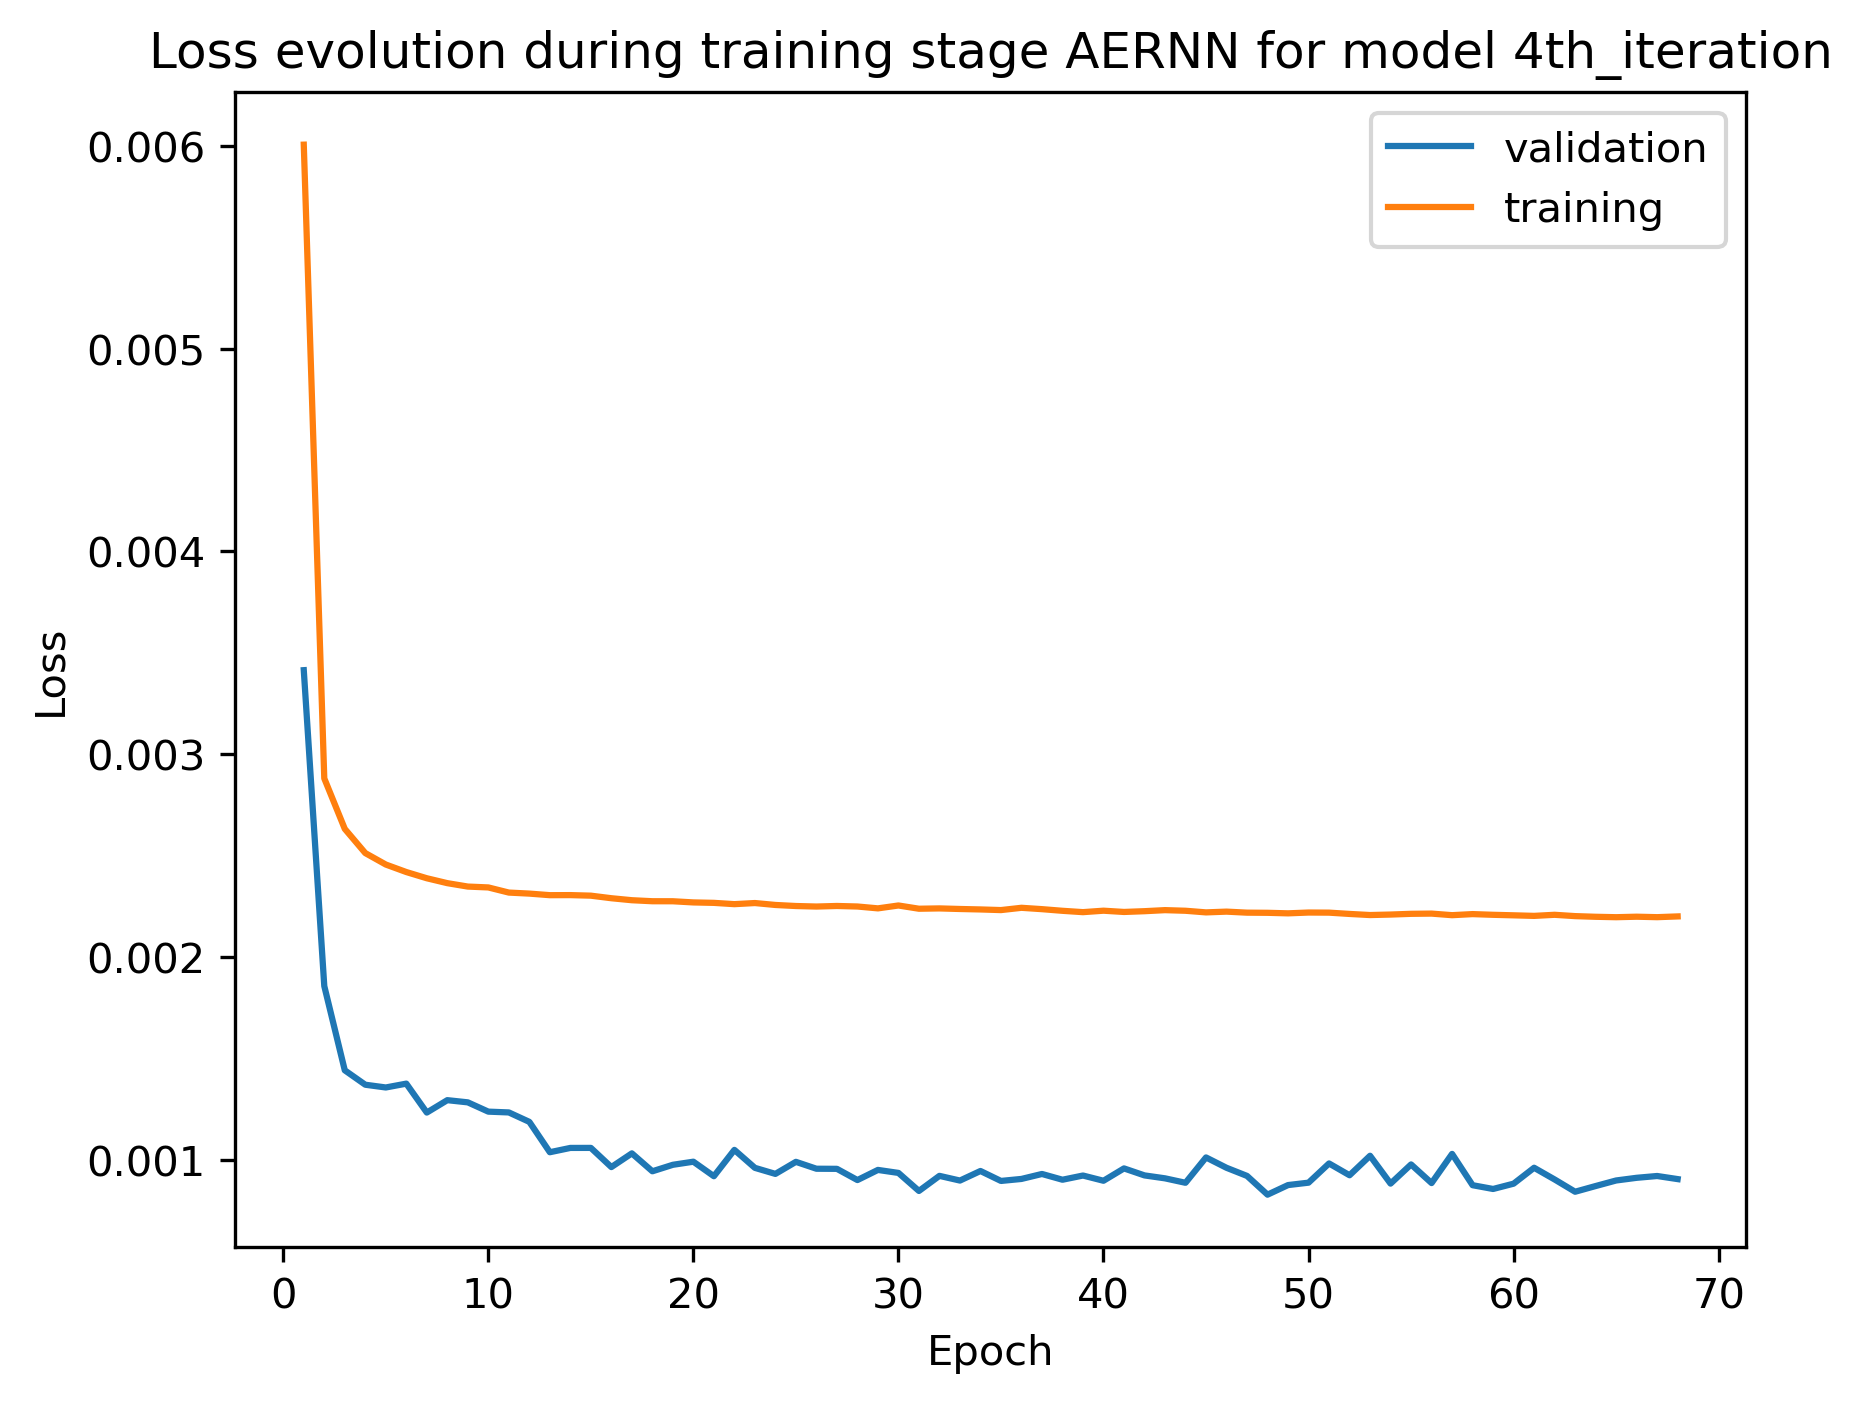

In [16]:
metrics.show_curves([curves], [modelo_final], 'AERNN')
print()

In [37]:
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

only_classifier = False
early_stop = 5
augmentation = False
batch_size = 256

stage = 'rnn'
curves = ft.train_final_model(modelo_final,
                                              stage,
                                                train_dataset,
                                                validation_dataset,
                                                ae_loss,
                                                rnn_loss,
                                                max_epochs,
                                                max_time,
                                                batch_size,
                                                10e-7,
                                                random_sampler,
                                                only_classifier,
                                                augmentation,
                                                early_stop,
                                                use_gpu,
                                                num_cpu)

torch.save(modelo_final.state_dict(), f'models/{modelo_final.name}.pth')


Setup finishied. Starting training...
(0.00 min) Epoch 1/300 -- Iteration 4 - Batch 4/482 - Train loss: 0.92140192  - Train acc: 0.7242 - Val loss: 0.00000000
(0.00 min) Epoch 1/300 -- Iteration 8 - Batch 8/482 - Train loss: 0.92435853  - Train acc: 0.7140 - Val loss: 0.00000000
(0.00 min) Epoch 1/300 -- Iteration 12 - Batch 12/482 - Train loss: 0.92472467  - Train acc: 0.7070 - Val loss: 0.00000000
(0.00 min) Epoch 1/300 -- Iteration 16 - Batch 16/482 - Train loss: 0.92488276  - Train acc: 0.7061 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 20 - Batch 20/482 - Train loss: 0.92456844  - Train acc: 0.7057 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 24 - Batch 24/482 - Train loss: 0.92584478  - Train acc: 0.7011 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 28 - Batch 28/482 - Train loss: 0.92539287  - Train acc: 0.7011 - Val loss: 0.00000000
(0.01 min) Epoch 1/300 -- Iteration 32 - Batch 32/482 - Train loss: 0.92452469  - Train acc: 0.7025 - Va

In [25]:
metrics.show_curves([curves], [modelo_final])
print()

TypeError: show_curves() missing 1 required positional argument: 'ae_rnn'

# RESULTS


Modelo 3rd_iteration
Precision: 0.396
Recall: 0.533
F1: 0.431


c:\Users\pmarc\.conda\envs\inteli_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


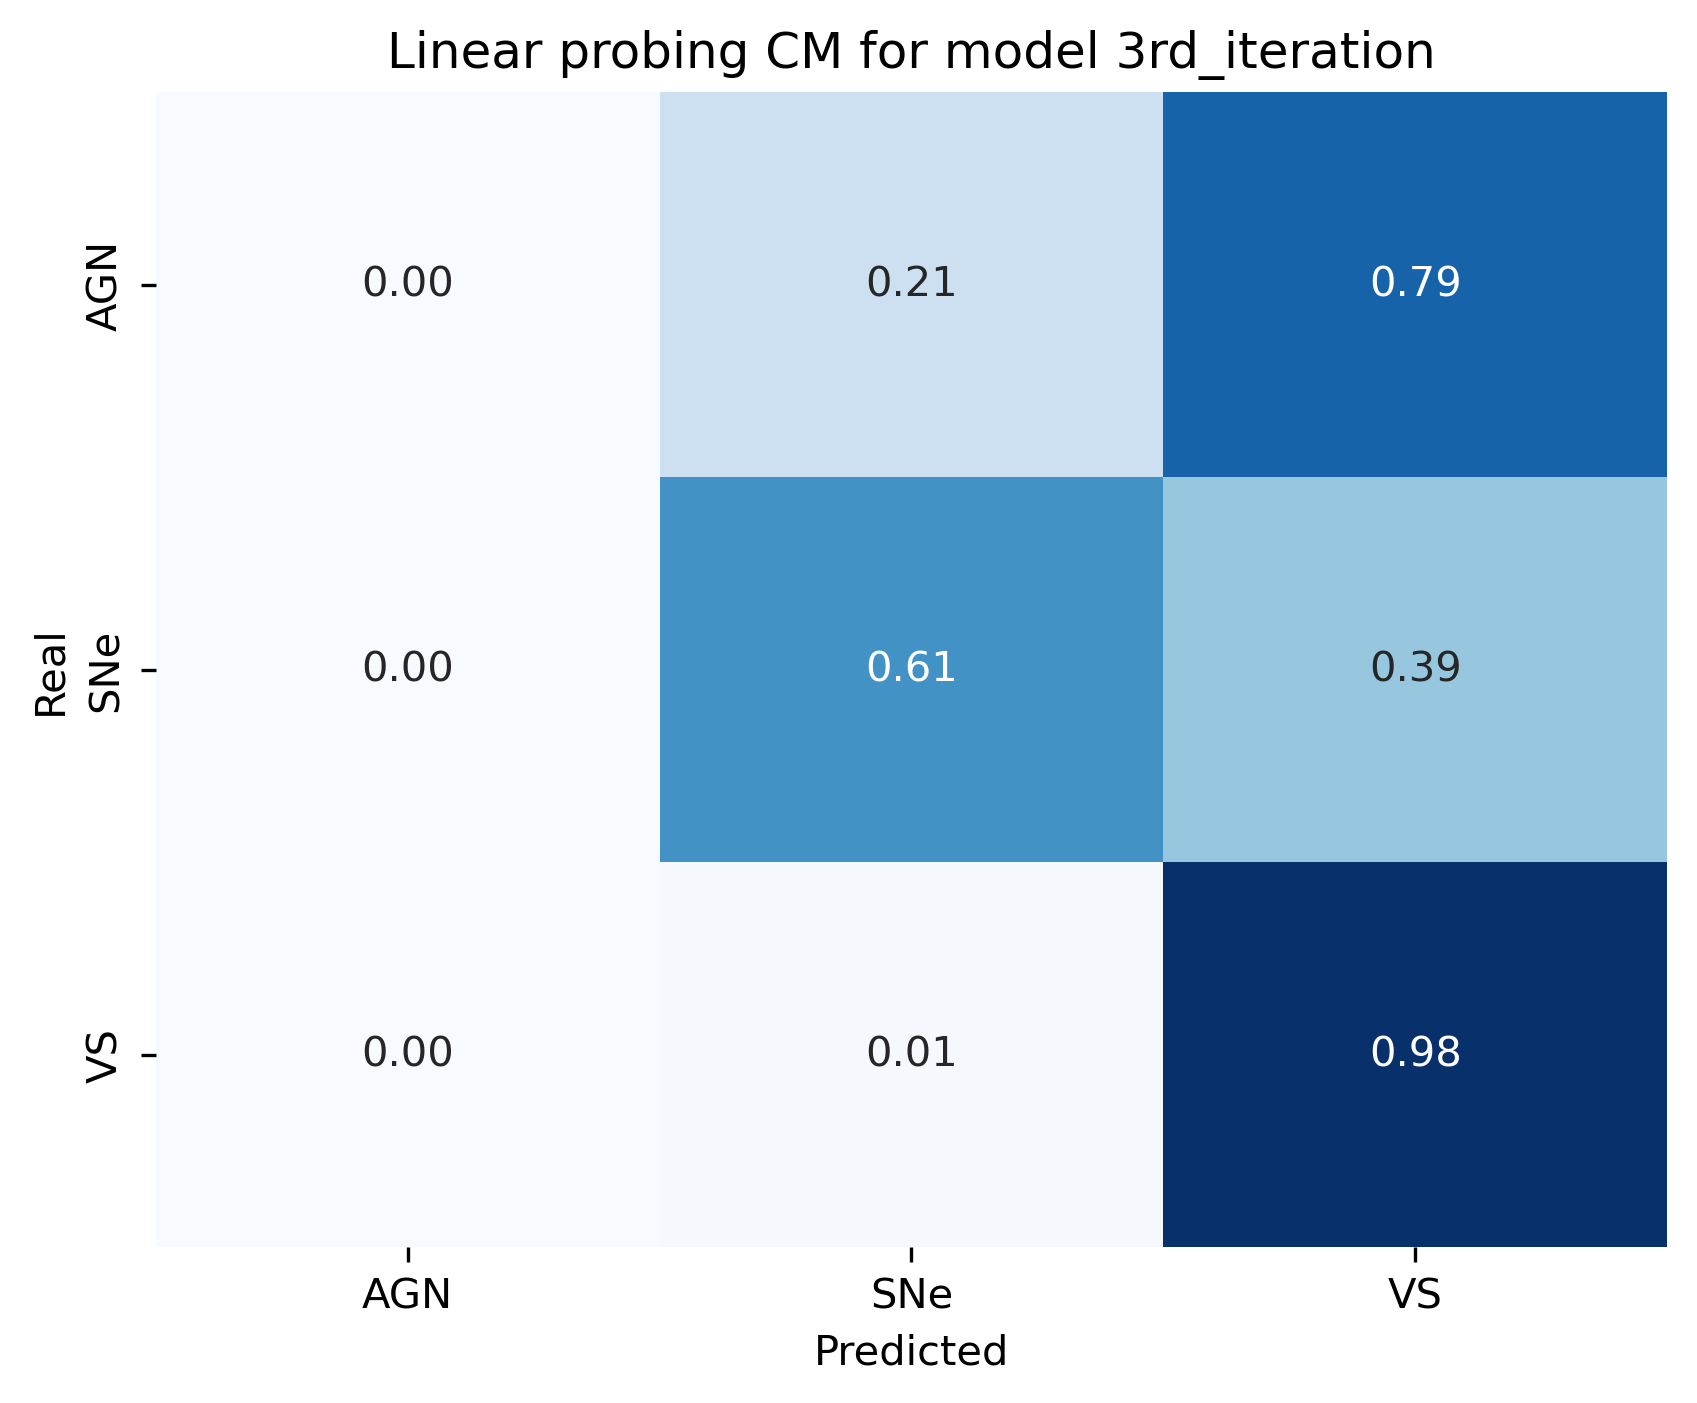

In [38]:
#validation
import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

modelo_final.cpu()
modelo_final.eval()


prediction = modelo_final(validation_dataset.tensors[0])

cm = confusion_matrix(validation_dataset.tensors[1], prediction.argmax(dim=1), normalize='true')
print(f'\nModelo {modelo_final.name}')
metrics.plot_matrix([modelo_final], [cm])
precision, recall, f1 = metrics.performance_metrics(validation_dataset.tensors[1], prediction.argmax(dim=1))

print(f'Precision: {precision:.3f}'
      f'\nRecall: {recall:.3f}'
      f'\nF1: {f1:.3f}')


Modelo 3rd_iteration
Precision: 0.626
Recall: 0.628
F1: 0.622


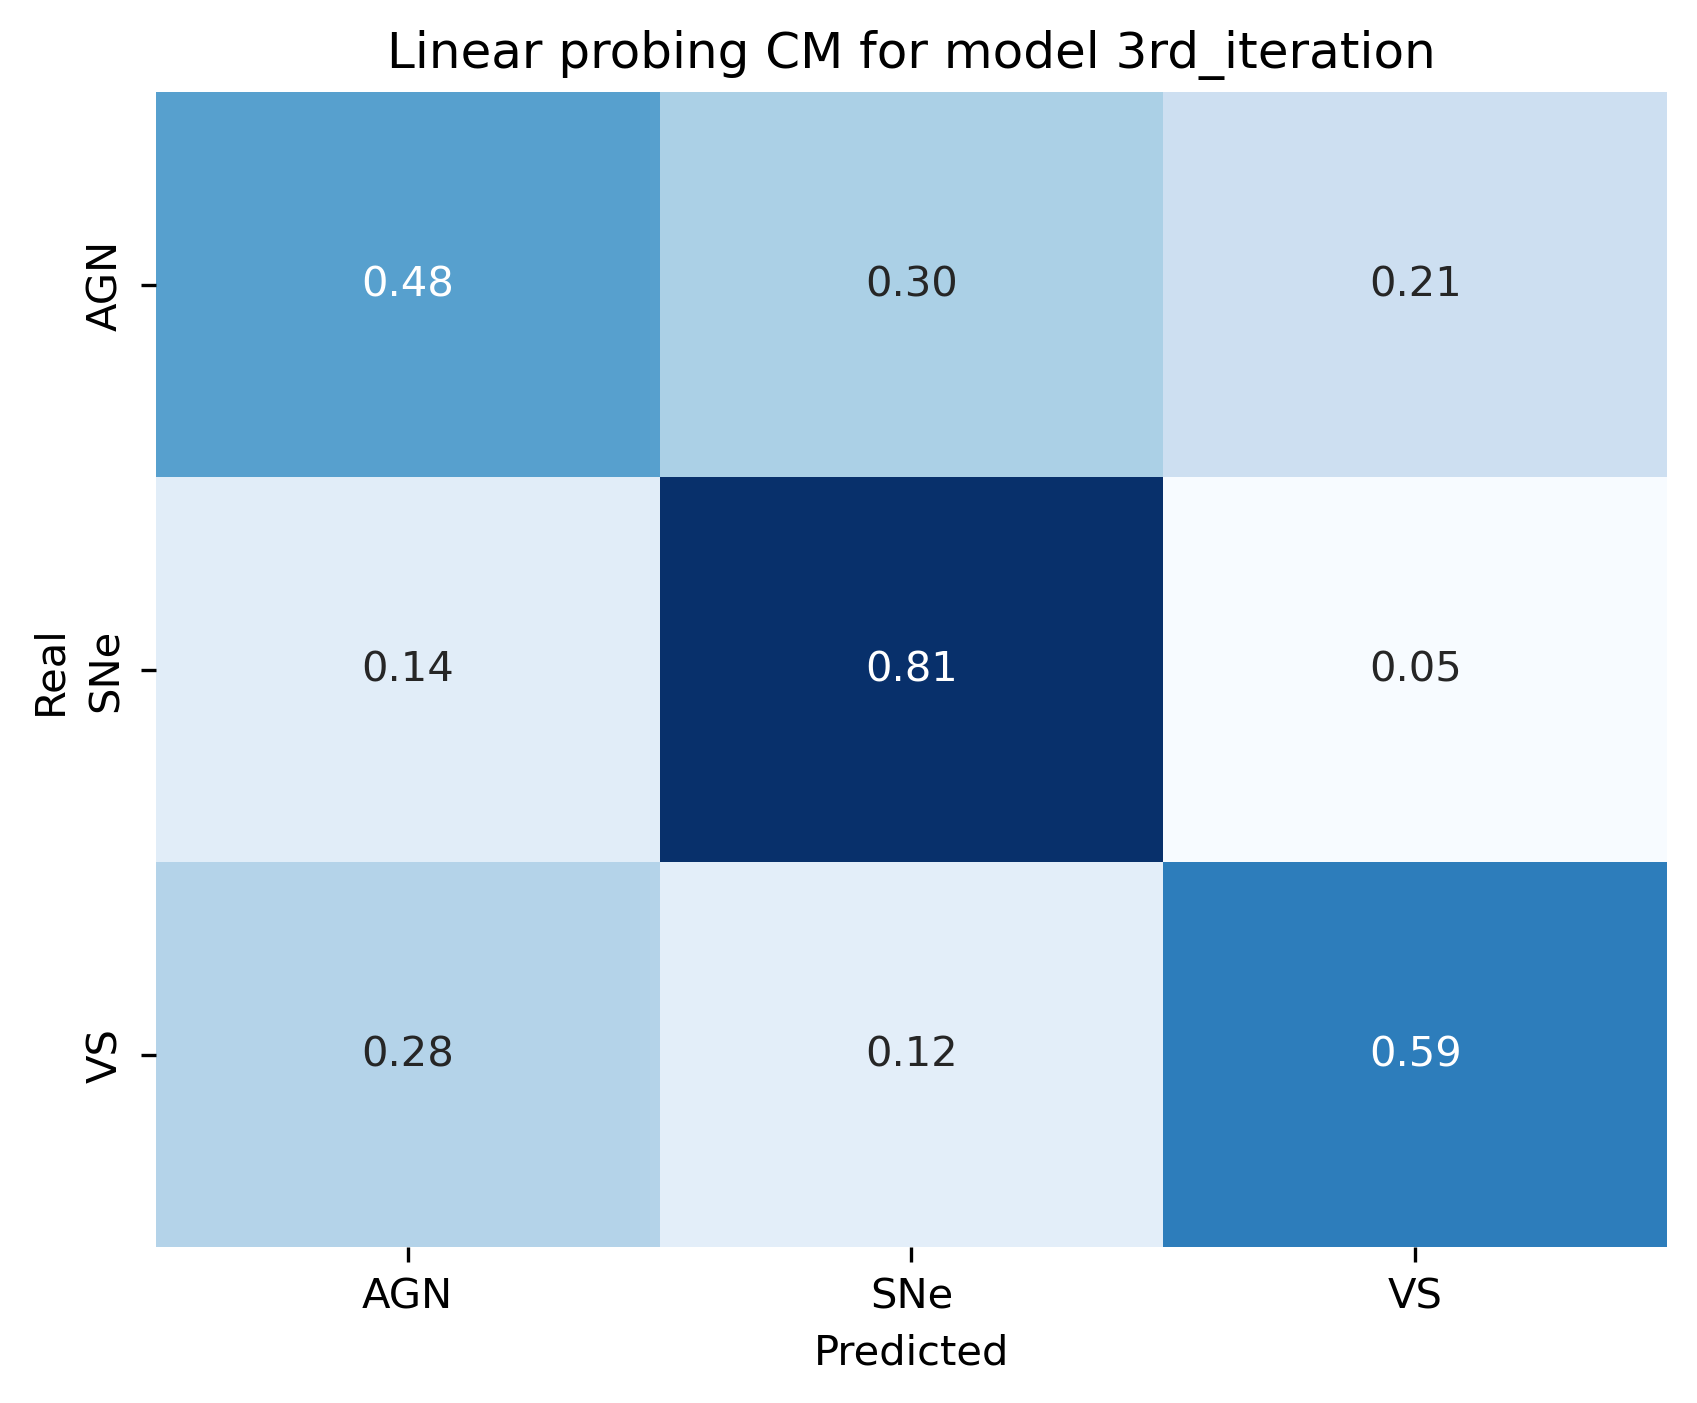

In [39]:
#test
modelo_final.eval()

prediction = modelo_final(test_dataset.tensors[0])
cm = confusion_matrix(test_dataset.tensors[1], prediction.argmax(dim=1), normalize='true')
print(f'\nModelo {modelo_final.name}')
metrics.plot_matrix([modelo_final], [cm])
precision, recall, f1 = metrics.performance_metrics(test_dataset.tensors[1], prediction.argmax(dim=1))

print(f'Precision: {precision:.3f}'
      f'\nRecall: {recall:.3f}'
      f'\nF1: {f1:.3f}')


# Random Forest

In [18]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

import src.final_model as fm
import src.final_training as ft
importlib.reload(fm)
importlib.reload(ft)
importlib.reload(src.final_training)
importlib.reload(src.final_model)

modelo_final = fm.FinalModel(128, 3, 'LSTM', 128, 1, 0.35,  3, name='2nd_iteration')

modelo_final.load_state_dict(torch.load(f'models/0_8_aernn.pth'))
modelo_final.eval()
modelo_final.cuda()

class_counts = torch.bincount(train_dataset.tensors[1].long())
class_weights = 1. / class_counts.float()
weights = class_weights[train_dataset.tensors[1].long()]

sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, num_workers=0, pin_memory=True)
features = []
labels = []

with torch.no_grad():
    for img, y_batch in train_loader:
        img = img.cuda()
        lat_spc = modelo_final.rnn_latent(img)
        features.append(lat_spc.cpu().numpy())
        labels.append(y_batch.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

C:\Users\pmarc\AppData\Local\Temp\ipykernel_23484\2208113070.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelo_final.load_state_dict(torch.load(f'models/0_8_aernn.

In [7]:
print(features.shape)
print(labels.shape)

(123227, 128)
(123227,)


In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs = -1)
rf_classifier.fit(features, labels)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [20]:
# Extract features from the validation dataset
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)
val_features = []
val_labels = []

with torch.no_grad():
    for img, y_batch in val_loader:
        if True:
            img = img.cuda()
        lat_spc = modelo_final.rnn_latent(img)
        val_features.append(lat_spc.cpu().numpy())
        val_labels.append(y_batch.numpy())

val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Predict and evaluate
val_predictions = rf_classifier.predict(val_features)
accuracy = np.mean(val_predictions == val_labels)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.3217
